In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Estimated fs: 100.00 Hz (dt ~ 10.00 ms)
Reps detected: 5

 rep  dur_s  rom_proxy_deg  peak_dw_rad_s  mean_dw_rad_s
 1   0.360       3.871         0.531          0.186     
 2   3.110      44.929         0.953          0.252     
 3   3.920      37.858         0.453          0.169     
 4   1.650      15.516         0.402          0.164     
 5   1.230      12.484         0.376          0.177     

Notes:
- rom_proxy_deg is a distance-like ROM proxy (directionless).
- effort_proxy grows when motion is fast + long.


C:\Users\dipes\AppData\Local\Temp\ipykernel_32148\3267494609.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(y, t))


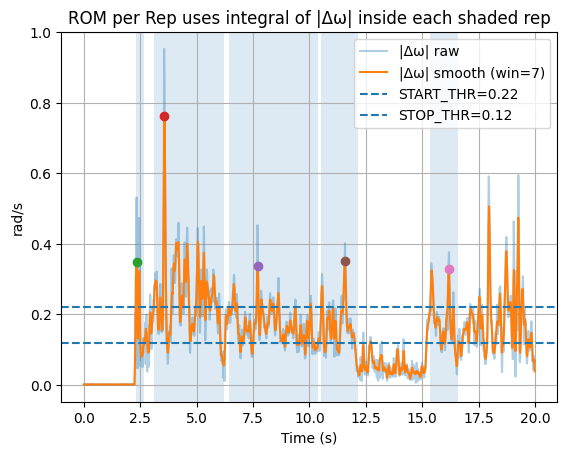

In [2]:

CSV_PATH = "dual_mpu_capture.csv"

# ---------- Segmentation tunables ----------
SMOOTH_WIN = 7

START_THR = 0.22      # tweak based on your data
STOP_THR  = 0.12
MIN_REP_DUR_S = 0.35
MIN_REST_S    = 0.15
# -----------------------------------------

def moving_avg(x, win):
    if win <= 1:
        return x.copy()
    k = np.ones(win) / win
    return np.convolve(x, k, mode="same")

def segment_reps(t, dw_s, fs):
    """Return list of reps: dict(start_i, end_i, peak_i, peak_val)."""
    min_rep_n  = int(np.ceil(MIN_REP_DUR_S * fs))
    min_rest_n = int(np.ceil(MIN_REST_S * fs))

    reps = []
    state = 0
    rep_start_i = None
    peak_i = None
    peak_val = -np.inf
    below_count = 0

    for i, v in enumerate(dw_s):
        if state == 0:  # idle
            if v >= START_THR:
                state = 1
                rep_start_i = i
                peak_i = i
                peak_val = v
                below_count = 0

        elif state == 1:  # in-rep
            if v > peak_val:
                peak_val = v
                peak_i = i

            if v <= STOP_THR:
                below_count += 1
                if below_count >= min_rest_n:
                    rep_end_i = i

                    # validate duration
                    if rep_end_i - rep_start_i >= min_rep_n:
                        reps.append({
                            "start_i": rep_start_i,
                            "end_i": rep_end_i,
                            "peak_i": peak_i,
                            "peak_val": float(peak_val),
                        })

                    # reset
                    state = 0
                    rep_start_i = None
                    peak_i = None
                    peak_val = -np.inf
                    below_count = 0
            else:
                below_count = 0

    return reps

def trapz_integral(y, t):
    """Trapezoidal integral of y over t."""
    return float(np.trapz(y, t))

def main():
    df = pd.read_csv(CSV_PATH)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna().reset_index(drop=True)

    # time axis (seconds)
    t = (df["T_US"] - df["T_US"].iloc[0]) / 1e6
    t = t.to_numpy()

    # estimate sampling frequency
    dt = np.median(np.diff(t)) if len(t) > 2 else 0.01
    fs = 1.0 / dt if dt > 0 else 100.0

    # gyro vectors (rad/s)
    w1 = df[["G1X","G1Y","G1Z"]].to_numpy()
    w2 = df[["G2X","G2Y","G2Z"]].to_numpy()

    # relative angular velocity magnitude
    dw = w1 - w2
    dw_mag = np.linalg.norm(dw, axis=1)
    dw_s   = moving_avg(dw_mag, SMOOTH_WIN)

    # segment reps on smoothed signal
    reps = segment_reps(t, dw_s, fs)

    # compute per-rep metrics using RAW dw_mag (not smoothed) for accuracy
    rows = []
    for k, r in enumerate(reps, 1):
        si, ei, pi = r["start_i"], r["end_i"], r["peak_i"]
        tt = t[si:ei+1]
        yy = dw_mag[si:ei+1]

        dur = float(tt[-1] - tt[0])
        rom_rad = trapz_integral(yy, tt)                  # ∫|Δω| dt  (radians)
        rom_deg = rom_rad * (180.0 / np.pi)

        peak = float(np.max(yy))
        mean = float(np.mean(yy))

        work_like = trapz_integral(yy**2, tt)             # ∫|Δω|^2 dt (rad^2/s)

        rows.append({
            "rep": k,
            "start_s": float(tt[0]),
            "end_s": float(tt[-1]),
            "dur_s": dur,
            "peak_dw_rad_s": peak,
            "mean_dw_rad_s": mean,
            "rom_proxy_rad": rom_rad,
            "rom_proxy_deg": rom_deg,
            "effort_proxy": work_like,
        })

    out = pd.DataFrame(rows)

    print(f"Estimated fs: {fs:.2f} Hz (dt ~ {dt*1000:.2f} ms)")
    print(f"Reps detected: {len(out)}\n")

    if len(out) > 0:
        # show a clean summary
        display_cols = ["rep","dur_s","rom_proxy_deg","peak_dw_rad_s","mean_dw_rad_s"]
        print(out[display_cols].to_string(index=False, justify="center", float_format=lambda x: f"{x:.3f}"))
        print("\nNotes:")
        print("- rom_proxy_deg is a distance-like ROM proxy (directionless).")
        print("- effort_proxy grows when motion is fast + long.")
    else:
        print("No reps detected. Tune START_THR/STOP_THR or record with clearer rest between reps.")

    # ---------- Plot ----------
    plt.figure()
    plt.plot(t, dw_mag, alpha=0.35, label="|Δω| raw")
    plt.plot(t, dw_s, label=f"|Δω| smooth (win={SMOOTH_WIN})")
    plt.axhline(START_THR, linestyle="--", label=f"START_THR={START_THR}")
    plt.axhline(STOP_THR, linestyle="--", label=f"STOP_THR={STOP_THR}")

    for _, r in enumerate(reps):
        si, ei, pi = r["start_i"], r["end_i"], r["peak_i"]
        plt.axvspan(t[si], t[ei], alpha=0.15)
        plt.plot(t[pi], dw_s[pi], marker="o")

    plt.title("ROM per Rep uses integral of |Δω| inside each shaded rep")
    plt.xlabel("Time (s)")
    plt.ylabel("rad/s")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
